# Demo: Encoding PSF variation with BLISS

This notebook demonstrates the capability of BLISS to encode and use PSF information to make more accurate predictions compared to a PSF-unaware model.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
from os import environ
from pathlib import Path
import re

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

import hydra

from bliss.catalog import TileCatalog
from bliss.encoder import Encoder
from bliss.simulator.decoder import ImageDecoder
from bliss.metrics import BlissMetrics, MetricsMode

In [6]:
# set bliss home directory and load config
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with hydra.initialize(config_path=".", version_base=None):
    cfg = hydra.compose("config")

## Load models and the data

We will compare two models:
1. A "PSF-unaware" model that has been trained on a single PSF (and has no information about the PSF during inference), and
2. A "PSF-aware" model that has been trained on images from different PSFs, and uses both the deconvolved image and the PSF parameters during inference.

In [7]:
# psf-unaware model (trained on single PSF)
base_model: Encoder = hydra.utils.instantiate(
    cfg.encoder,
    input_transform_params={"use_deconv_channel": False, "concat_psf_params": False}
)
base_model.load_state_dict(torch.load(Path(cfg.paths.pretrained_models) / "psf_unaware.pt"))
base_model.eval();

# psf-aware model (trained with varying PSFs)
psf_model: Encoder = hydra.utils.instantiate(cfg.encoder)
psf_model.load_state_dict(torch.load(Path(cfg.paths.pretrained_models) / "psf_aware.pt"));
psf_model.eval();


                 from  n    params  module                                  arguments                     
  0                -1  1      3328  yolov5.models.common.Conv               [2, 64, 5, 1]                 
  1                -1  3     12672  yolov5.models.common.Conv               [64, 64, 1, 1]                
  2                -1  1     73984  yolov5.models.common.Conv               [64, 128, 3, 2]               
  3                -1  1    147712  yolov5.models.common.Conv               [128, 128, 3, 1]              
  4                -1  1    295424  yolov5.models.common.Conv               [128, 256, 3, 2]              
  5                -1  6   1118208  yolov5.models.common.C3                 [256, 256, 6]                 
  6                -1  1   1180672  yolov5.models.common.Conv               [256, 512, 3, 2]              
  7                -1  9   6433792  yolov5.models.common.C3                 [512, 512, 9]                 
  8                -1  1   4720640  

We will evaluate these models on two images. Both are generated from the same catalog; they have sources at the same locations with the same parameters, but the only difference is one has a more localized PSF than the other, which is more spread out. We can think of these as being the PSFs on a clear night vs. a cloudy night, but looking at the same region of the sky.

In [8]:
# load data
with open("data/clear_psf.pt", "rb") as f:
    clear_data = torch.load(f)

with open("data/cloudy_psf.pt", "rb") as f:
    cloudy_data = torch.load(f)

dataloader = DataLoader(clear_data + cloudy_data)

Now let's plot the images and PSFs to see the differences:

In [9]:
# construct PSF images from saved params
decoder: ImageDecoder = hydra.utils.instantiate(cfg.simulator.decoder)
clear_psf = decoder._get_psf(clear_data[0]["psf_params"])
cloudy_psf = decoder._get_psf(cloudy_data[0]["psf_params"])

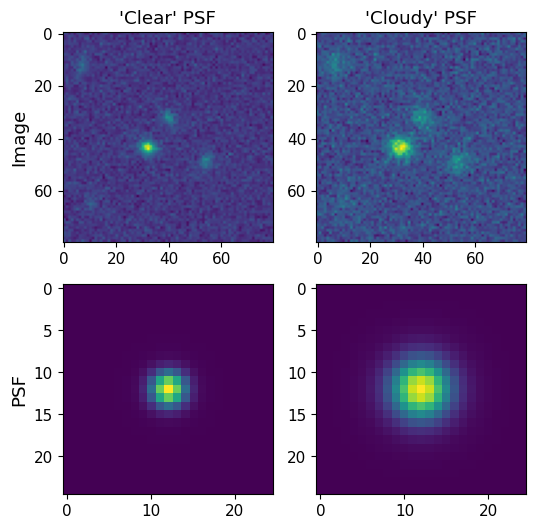

In [13]:
# plot images and PSFs
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0, 0].set_title("'Clear' PSF", size="large")
ax[0, 1].set_title("'Cloudy' PSF", size="large")
ax[0, 0].set_ylabel("Image", rotation=90, size="large")
ax[1, 0].set_ylabel("PSF", rotation=90, size="large")

ax[0, 0].imshow(clear_data[0]["images"][2])  # plot r band
ax[0, 1].imshow(cloudy_data[0]["images"][2])

ax[1, 0].imshow(clear_psf[0].original.image.array)
ax[1, 1].imshow(cloudy_psf[0].original.image.array)

## Make predictions on both models

In [14]:
# instantiate the Trainer
trainer = hydra.utils.instantiate(cfg.training.trainer, accelerator="cpu", logger=None)

# make predictions
base_results = trainer.predict(base_model, dataloader)
psf_results = trainer.predict(psf_model, dataloader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

## Plot predictions and true locations

In [15]:
# get true catalog and crop to account for tiles cropped by model
true_catalog = TileCatalog(cfg.encoder.tile_slen, clear_data[0]["tile_catalog"])
true_catalog = true_catalog.symmetric_crop(base_model.tiles_to_crop).to_full_params()
true_locs = true_catalog.plocs

# get predicted locations
px_to_crop = 0 #base_model.tiles_to_crop * base_model.tile_slen
est_locs = [
    [
        base_results[0]["est_cat"].to_full_params().plocs + px_to_crop,
        base_results[1]["est_cat"].to_full_params().plocs + px_to_crop
    ],
    [
        psf_results[0]["est_cat"].to_full_params().plocs + px_to_crop,
        psf_results[1]["est_cat"].to_full_params().plocs + px_to_crop
    ]
]

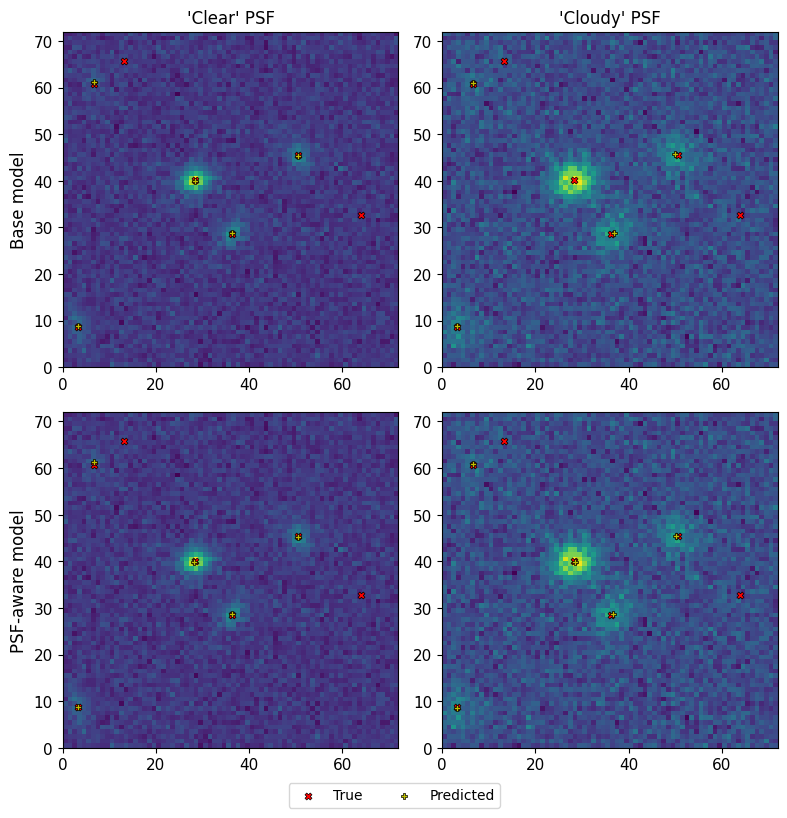

In [16]:
# Plot true and estimated predictions for both models and both images
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

true_plot_args = dict(color="r", s=25, marker="X", edgecolors="k", linewidth=0.5, label="True")
est_plot_args = dict(color="y", s=25, marker="P", edgecolors="k", linewidth=0.5, label="Predicted")

for row in range(2):
    for col in range(2):
        image = clear_data[0]["images"] if col == 0 else cloudy_data[0]["images"]
        image = image[2, 4:76, 4:76]
        
        ax[row, col].imshow(image, origin="lower", extent=(0, 72, 0, 72))
        ax[row, col].scatter(true_locs[0, :, 1], true_locs[0, :, 0], **true_plot_args)
        ax[row, col].scatter(est_locs[row][col][0, :, 1], est_locs[row][col][0, :, 0], **est_plot_args)

# add row and column labels
ax[0, 0].set_ylabel("Base model", rotation=90, size=12);
ax[1, 0].set_ylabel("PSF-aware model", rotation=90, size=12);
ax[0, 0].set_title("'Clear' PSF", size=12);
ax[0, 1].set_title("'Cloudy' PSF", size=12);

# add legend
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0, -0.03, 1, 1), fontsize=10)
fig.tight_layout()

The PSF-unaware model performs well on the "clear" image, but much more poorly on the "cloudy" image; it misses the brightest source altogether, and some of the other predicted sources are offset from the true location. The PSF-aware model, on the other hand, is able to deal with the difference in PSF and performs equally well on the "cloudy" image as the "clear" image.

Finally, let's take a look at some metrics for the PSF-unaware model compared to the PSF-aware model.

In [17]:
metrics = BlissMetrics(mode=MetricsMode.FULL)
keys = ["f1", "avg_distance_keep", "(disk|bulge)_.*_mae", ".*_r_mae"]

results = {
    "psf-unaware": { key: val for key, val in metrics(true_catalog, base_results[1]["est_cat"].to_full_params()).items()},
    "psf-aware": { key: val for key, val in metrics(true_catalog, psf_results[1]["est_cat"].to_full_params()).items()}
}

df = pd.DataFrame.from_dict(results, orient="index")
df[[col for col in df.columns if any([re.match(pattern, col) for pattern in keys])]]

,f1,disk_frac_mae,bulge_frac_mae,disk_q_mae,bulge_q_mae,disk_hlr_mae,bulge_hlr_mae,gal_fluxes_r_mae,star_fluxes_r_mae
psf-unaware,0.727273,0.286914,0.286914,0.434616,0.109457,0.659329,0.533172,4460.177246,962.876343
psf-aware,0.833333,0.067407,0.067407,0.267202,0.381148,0.408697,0.372264,5656.589355,536.611084


We see that across a majority of the relevant metrics, the psf-aware model outperforms the psf-unaware model, demonstrating the effectiveness of using PSF information in the encoder.